In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel, MaternKernel, CosineKernel
from skgpytorch.models import SVGPRegressor, SGPRegressor

In [3]:
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
# from utilities import plot
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from gpytorch.constraints import GreaterThan
from skgpytorch.metrics import mean_squared_error, negative_log_predictive_density
import time
import numpy as np

# from datasets.dataset_load import dataset_loader
from utilities import plot,fits,gmm,errors,predict,preprocess

# device = "cpu"
# torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type(torch.FloatTensor)


In [4]:
train ={1:{
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                3: {
                    'start_time': "2011-04-19" ,
                    'end_time': "2011-05-22"
                },
                
                5: {
                    'start_time': "2011-04-22" ,
                    'end_time': "2011-06-01"
                },2: {
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
               
                }
test = {6: {
                    'start_time': "2011-05-25" ,
                    'end_time': "2011-06-13"
                },}
appliances = ["Refrigerator"]

In [26]:
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler


def dataset_load(appliances, train, test=None):
    x_train = []
    y_train = []
    x_train_timestamp = []
    x_train_mean = []
    x_train_std = []
    x_train_max_min = []
    x_train_main = []
    x_train_main_dif = []
    n = 99
    units_to_pad = n // 2
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    scaler_mean = StandardScaler()
    scaler_std = StandardScaler()
    scaler_max_min = StandardScaler()
    scaler_main = StandardScaler()
    scaler_dif = StandardScaler()
    # train
    for key, values in train.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        x_train_main.extend(x)
        y = df[appliances[0]].values
        x_train_main_dif.extend(x- y)
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])
        # print(0)
        x_train_mean.extend(jnp.mean(x, axis=1))
        # print(0)
        x_train_std.extend(jnp.std(x, axis=1))
        x_train_max_min.extend(jnp.max(x, axis=1)-jnp.min(x,axis=1))
        x_train.extend(x)
        y_train.extend(y)
        x_train_timestamp.extend(torch.tensor(timestamp_train))


    x_train = jnp.array(x_train)
    y_train = jnp.array(y_train).reshape(-1, 1)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(-1,1)
    x_train_main = jnp.array(x_train_main).reshape(-1,1)
    x_train_mean = jnp.array(x_train_mean).reshape(-1,1)
    x_train_std =  jnp.array(x_train_std).reshape(-1,1)
    x_train_max_min =  jnp.array(x_train_max_min).reshape(-1,1)
    x_train_main_dif = jnp.array(x_train_main_dif).reshape(-1,1)


    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)
    x_train_main = scaler_main.fit_transform(x_train_main)
    x_train_mean = scaler_mean.fit_transform(x_train_mean)
    x_train_std = scaler_std.fit_transform(x_train_std)
    x_train_max_min = scaler_max_min.fit_transform(x_train_max_min)
    x_train_main_dif = scaler_dif.fit_transform(x_train_main_dif)

    # test
    x_test = []
    y_test = []
    x_test_timestamp = []
    x_test_mean = []
    x_test_std = []
    x_test_max_min = []
    x_test_timestamp_true =[]
    x_test_main = []
    x_test_main_dif = []

    for key, values in test.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values 
        x_test_main.extend(x)
        y = df[appliances[0]].values

        x_test_main_dif.extend(x-y)
        timestamp_true = df["Timestamp"].values
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values
        x = jnp.pad(x, (units_to_pad, units_to_pad),
                    'constant', constant_values=(0, 0))
        x = jnp.array([x[i: i + n] for i in range(len(x) - n + 1)])

        x_test_mean.extend(jnp.mean(x, axis=1))
        x_test_std.extend(jnp.std(x, axis=1))
        x_test_max_min.extend(jnp.max(x, axis=1)-jnp.min(x, axis=1))
        x_test.extend(x)
        y_test.extend(y)
        x_test_timestamp_true.extend(timestamp_true)
        x_test_timestamp.extend(timestamp)

    x_test = jnp.array(x_test)
    y_test = jnp.array(y_test).reshape(-1, 1)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(-1,1)
    x_test_main = jnp.array(x_test_main).reshape(-1,1)
    x_test_mean = jnp.array(x_test_mean).reshape(-1,1)
    x_test_std =  jnp.array(x_test_std).reshape(-1,1)
    x_test_max_min =  jnp.array(x_test_max_min).reshape(-1,1)
    x_test_main_dif = jnp.array(x_test_main_dif).reshape(-1,1)

    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)
    x_test_mean = scaler_mean.transform(x_test_mean)
    x_test_std = scaler_std.transform(x_test_std)
    x_test_max_min = scaler_max_min.transform(x_test_max_min)
    x_test_main = scaler_main.transform(x_test_main)
    x_test_main_dif = scaler_dif.transform(x_test_main_dif)
#     y_test = scaler_y.transform(y_test)

    x_train_features = jnp.concatenate((x_train_main, x_train_mean, x_train_std, x_train_max_min, x_train_main_dif), axis=1).reshape(x_train.shape[0], 5)
    x_test_features = jnp.concatenate((x_test_main, x_test_mean, x_test_std, x_test_max_min, x_test_main_dif), axis=1).reshape(x_test.shape[0], 5)

    x_train = jnp.array(x_train).reshape(x_train.shape[0], n)
    y_train = jnp.array(y_train)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1)
    x_test = jnp.array(x_test).reshape(x_test.shape[0], n)
    y_test = jnp.array(y_test)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1).to(torch.float64)

    scalers = np.array([scaler_x, scaler_y, scaler_time, scaler_main, scaler_mean, scaler_std, scaler_max_min, scaler_dif])
    return x_train, y_train, x_test, y_test, x_train_features, x_test_features, x_train_timestamp, x_test_timestamp, scalers, x_test_main


In [27]:
x_train, y_train, x_test, y_test, x_train_features, x_test_features, x_train_timstamp, x_test_timestamp, scalers, x_test_main = dataset_load(appliances, train, test)

In [28]:
scalers

array([StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler(), StandardScaler(),
       StandardScaler(), StandardScaler()], dtype=object)

In [29]:
x_train_dif= scalers[-1].inverse_transform(x_train_features[:,-1].reshape(-1,1))
x_test_dif = scalers[-1].inverse_transform(x_test_features[:,-1].reshape(-1,1))

In [30]:
x1 =  scalers[3].inverse_transform(x_train_features[:,0].reshape(-1,1))
x2 =  scalers[3].inverse_transform(x_test_features[:,0].reshape(-1,1))

In [32]:
x_tr_mean = scalers[4].inverse_transform(x_train_features[:,1].reshape(-1,1))
x_tes_mean = scalers[4].inverse_transform(x_test_features[:,1].reshape(-1,1))

In [36]:
x_tr_std = scalers[5].inverse_transform(x_train_features[:,2].reshape(-1,1))
x_tes_std = scalers[5].inverse_transform(x_test_features[:,2].reshape(-1,1))

In [39]:
x_tr_max_min = scalers[6].inverse_transform(x_train_features[:,3].reshape(-1,1))
x_tes_max_min = scalers[6].inverse_transform(x_test_features[:,3].reshape(-1,1))

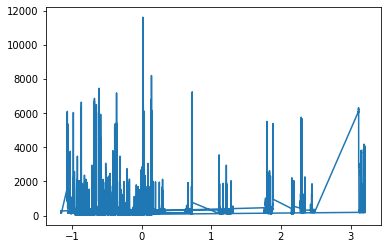

In [78]:
plt.plot(x_train_timstamp[:], x1[:], label = "Main")

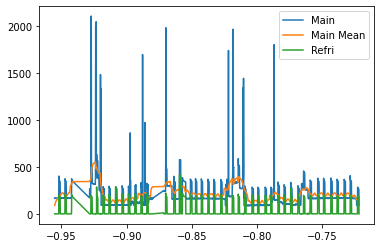

In [70]:
idx = 3000
plt.plot(x_train_timstamp[:idx], x1[:idx], label = "Main")
plt.plot(x_train_timstamp[:idx], x_tr_mean[:idx], label="Main Mean")
# plt.plot(x_train_timestamp[:idx], x_tr_std[:idx], label="Main std")
# plt.plot(x_train_timestamp[:idx], x_tr_max_min[:idx], label="Main Max_Min")
# plt.plot(x_train_timestamp[:idx], x_train_dif[:idx], label="Main Ref Diff")
plt.plot(x_train_timstamp[:idx], scalers[1].inverse_transform(y_train.reshape(-1,1))[:idx], label = "Refri")
plt.legend()

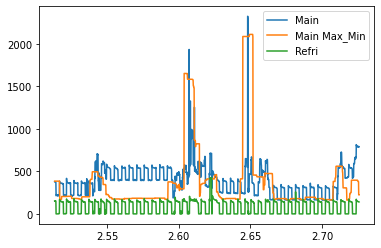

In [77]:
idx = 3000
plt.plot(x_test_timestamp[:idx], x2[:idx], label = "Main")
plt.plot(x_test_timestamp[:idx], x_tes_mean[:idx], label="Main Mean")
# plt.plot(x_test_timestamp[:idx], x_tes_std[:idx], label="Main std")
plt.plot(x_test_timestamp[:idx], x_tes_max_min[:idx], label="Main Max_Min")
# plt.plot(x_test_timestamp[:idx], x_test_dif[:idx], label="Main Ref Diff")
plt.plot(x_test_timestamp[:idx],y_test[:idx], label = "Refri")
plt.legend()

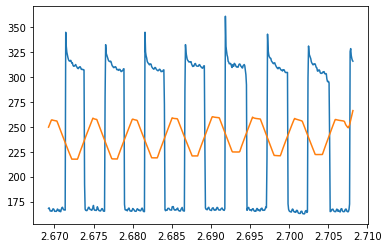

In [53]:
idx = 2750
plt.plot(x_test_timestamp[2200:idx], x2[2200:idx], label = "Main")
plt.plot(x_test_timestamp[2200:idx], x_tes_mean[2200:idx], label="Main Mean")
# plt.plot(x_test_timestamp[:idx], x_tes_std[:idx], label="Main std")
# plt.plot(x_test_timestamp[:idx], x_tes_max_min[:idx], label="Main Max_Min")
# plt.plot(x_test_timestamp[:idx], x_test_dif[:idx], label="Main Ref Diff")
# plt.plot(x_test_timestamp[:idx],y_test[:idx], label = "Refri")

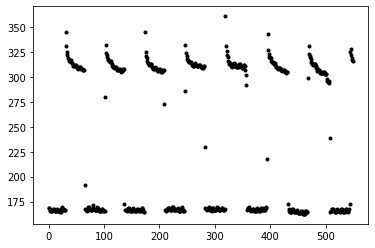

In [54]:
plt.plot( x2[2200:idx], 'k.')

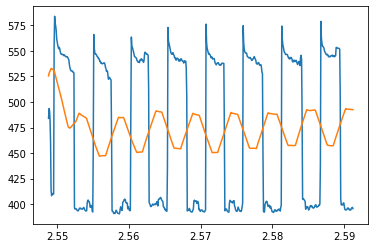

In [61]:
idx = 1100
plt.plot(x_test_timestamp[500:idx], x2[500:idx], label = "Main")
plt.plot(x_test_timestamp[500:idx], x_tes_mean[500:idx], label="Main Mean")

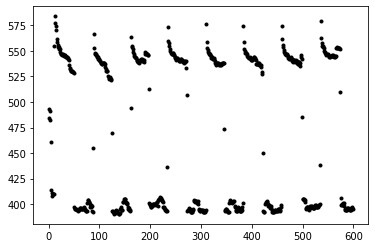

In [62]:
plt.plot(x2[500:idx], 'k.')

In [63]:
x2[2200:2750].max() - x2[2200:2750].min(), x2[500:1100].max() - x2[500:1100].min()

(198.28151, 193.65286)

In [65]:
min_val = x2[500:1100].min() - x2[2200:2750].min() 
min_val

227.74577

In [67]:
x2_mod = x2[500:1100] - min_val

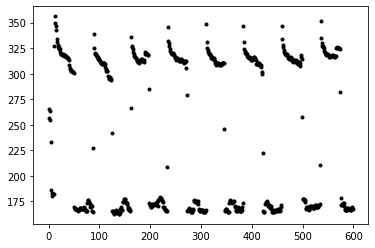

In [68]:
plt.plot(x2_mod,'k.')